### Notebook to examine residual axis for cloud patches

In [3]:
%matplotlib inline 
import os
import re
import gc
import cv2
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pylab import *
from matplotlib.colors import Colormap

import tensorflow as tf
from tensorflow.contrib.data import parallel_interleave

In [4]:
from scipy.stats import mode

In [5]:
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as po
import plotly.io as pio

In [6]:
def log_loader(basedir, verbose=False):
    data_list = []
    
    files = glob.glob(os.path.join(basedir,"*.txt"))
    #if verbose:
    #    print(len(files))
        
    for file in files:  
        with open(file, 'r') as f:
            lines = f.read()
            data = []
            for line in lines.split('\n'):
                #print(line)
                j = line.replace(' ', '')
                if len(j) > 0:
                    data.append(float(j))
        data_list.append(np.array(data))
    return data_list

In [78]:
def res_log_loader(basedir, verbose=False, angle=0):
    data_list = []
    
    files = glob.glob(os.path.join(basedir,"*.txt"))
    #if verbose:
    #    print(len(files))
    
    for file in files:  
        with open(file, 'r') as f:
            lines = f.read()
            data = []
            for line in lines.split('\n'):
                #print(line)
                j = line.replace(' ', '')
                if len(j) > 0:
                    ia = float(j) + float(angle)  # Assume angle is negtive
                    #print(j, angle, ia)
                    data.append(ia)
        data_list.append(np.array(data))
    return data_list

#### Collect Log files

In [1]:
base_datadir = "/home/tkurihana/Research/Paxis/protocol/rotation" 

In [8]:
nclusters=20

In [9]:
expnames_list = [67011582 , "m2_02_global_2000_2018_band28_29_31"]

In [63]:
def run_loader(base_datadir, expname=None, angles_list=[], nclusters=0):
    """ load data for indivisual autoencoder experiment i.e. expname
    """
    rangle_list = []  # residual angle
    oangle_list = []  # original angle
    for angle in angles_list:
        tmp_dict = {}
        res_dict = {}
        for cluster in range(nclusters):
            datadir = os.path.join(base_datadir,
                   "log_rot{}/{}/cluster-{}_N-{}".format(
                       angle, expname, cluster, nclusters
                   )                
            )
            tmp_dict[f'cluster-{cluster}'] = log_loader(datadir)
            res_dict[f'cluster-{cluster}'] = res_log_loader(datadir, angle=angle)
            #array = np.array(log_loader(datadir))
            #tmp_dict[f'cluster-{cluster}'] = array
            #res_dict[f'cluster-{cluster}'] = array - float(angle)
        
        oangle_list.append(tmp_dict)
        rangle_list.append(res_dict)
    return oangle_list, rangle_list

In [11]:
angles_list = [0, -90, -180, -270]

In [79]:
oangle1_list, rangle1_list = run_loader(
    base_datadir, expname=expnames_list[0], angles_list=angles_list, nclusters=nclusters)

In [80]:
oangle2_list, rangle2_list = run_loader(
    base_datadir, expname=expnames_list[1], angles_list=angles_list, nclusters=nclusters)

#### Sanity check with distribution comparison

In [100]:
def check_hist(data1, data2, cluster=0,bins=60):
    fig = plt.figure()
    data = [data1, data2]
    for i in range(2):
        ix = i+1
        ax = plt.subplot(1,2,ix)
        alist = data[i][f'cluster-{cluster}']  # list of numpy array
        array = np.concatenate(alist, axis=0)
        
        #####
        #  0-360 degree
        #####
        ndx = np.where(array < 0)
        array[ndx] += 360
        
        # new
        jdx = np.where(array > 180)
        array[ndx] -= 180
        
        plt.hist(array, color=f'C{i}',bins=bins)
        #ax.set_xlim(0,360)
        ax.set_xticks([0,90,180,270, 360])
    fig.tight_layout()
    plt.show()

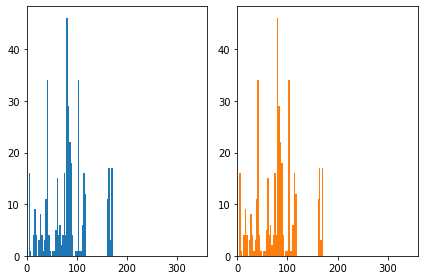

In [71]:
check_hist(oangle1_list[0], rangle1_list[0])

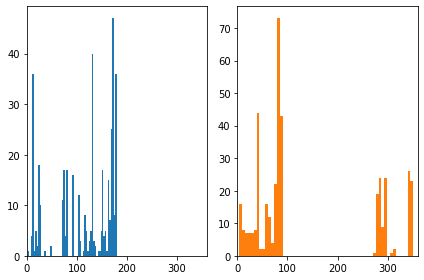

In [76]:
check_hist(oangle1_list[1], rangle1_list[1])

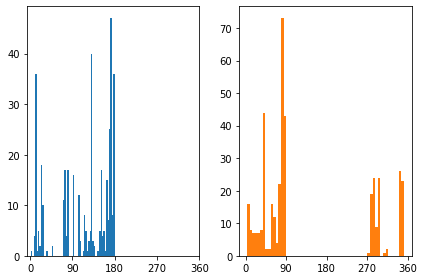

In [99]:
check_hist(oangle1_list[1], rangle1_list[1])

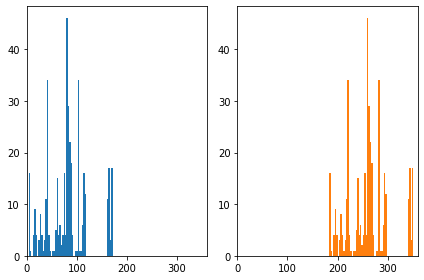

In [78]:
check_hist(oangle1_list[2], rangle1_list[2])

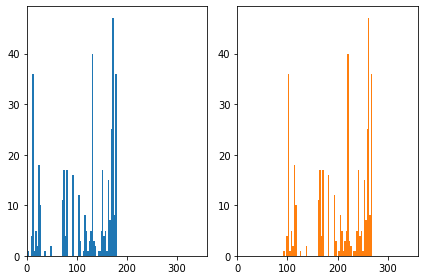

In [79]:
check_hist(oangle1_list[3], rangle1_list[3])

In [101]:
def check_all_hist(data, cluster=0,bins=60, figsize=(6,4), modify=False):
    fig = plt.figure(figsize=figsize)
    for i in range(4):
        ix = i+1
        ax = plt.subplot(2,2,ix)
        alist = data[i][f'cluster-{cluster}']  # list of numpy array
        array = np.concatenate(alist, axis=0)
        
        #####
        #  0-360 degree
        #####
        ndx = np.where(array < 0)
        array[ndx] += 360
        
        if modify:
            # new
            jdx = np.where(array > 180)
            array[ndx] -= 180
        
        plt.hist(array, color=f'C{i}',bins=bins)
        ax.set_xlim(0,360)
        ax.set_xticks([i for i in range(0,361,90)])
        ax.set_title(f"Rotate {90*i} degree", fontsize=14)
        if i  >=2:
            ax.set_xlabel("Degree", fontsize=12)
    fig.tight_layout()
    plt.show()

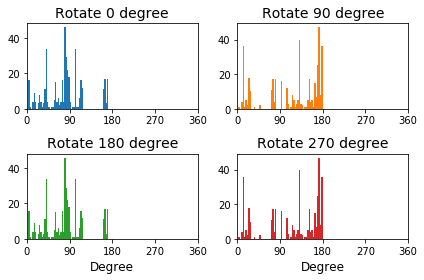

In [53]:
check_all_hist(oangle1_list)

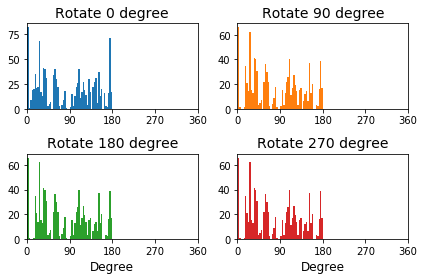

In [55]:
check_all_hist(oangle2_list)

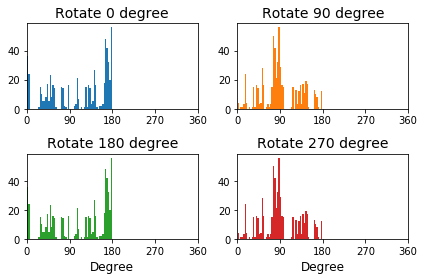

In [107]:
check_all_hist(oangle1_list, cluster=1)

----------

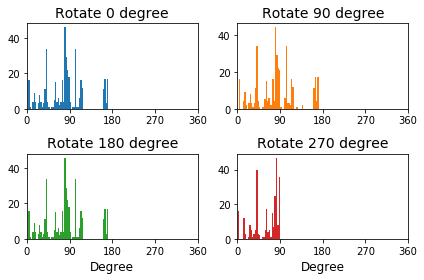

In [102]:
check_all_hist(rangle1_list, modify=True)

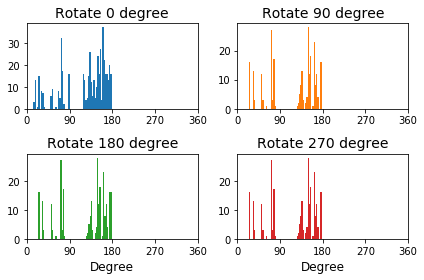

In [110]:
check_all_hist(oangle2_list, cluster=2,modify=True)

----------------
### Visualize by wind rose

#### Prep for visualization: summarizing results

In [15]:
def compute_dfangle(result_angle_list, aindex=0, nclusters=None, topK=None, expname=None,nangle=16, debug=False):
    """ results_angle_list: list of 4 different rotated results:
                            list[list,list,list,list]
        aindex: which angle should be visualize. 0=0, 3=-270 rotated by clockwise
    """
    logs_list = []
    dcheck_list = [] # for debug with matplotlib
    for cluster in range(nclusters):
        tmp_list = []
        logs = result_angle_list[aindex][f'cluster-{cluster}']  # list of numpy array
        
        tmp_list = []
        for log in logs:
            # mode
            md = mode(log)
            tmp_list.extend(md[0])
        dcheck_list.append(tmp_list)
        
        # dataframe
        angles = []
        ag = np.linspace(0,360,nangle)
        amax = 360+ag[1]
        for idx, i in enumerate(ag[:-1]):
            tmp = list(filter(lambda x : x  > ag[idx] and x <= ag[idx+1], tmp_list))
            angles.append(len(tmp))
        df = pd.DataFrame(np.array(angles))
        df.columns = ['frequency']
        df['theta'] = np.array([ float((i+ag[idx+1])/2) for idx, i in enumerate(ag[:-1])])
        
        logs_list.append(df)
    
    if debug:
        return logs_list, dcheck_list
    else:
        return logs_list

In [16]:
log_ri_list = []
result_angle_list = oangle1_list
for i in range(len(angles_list)):
    log_ri_list.append(
        compute_dfangle(result_angle_list, aindex=i, nclusters=nclusters,nangle=15, debug=False)
    )

In [17]:
log_nori_list = []
result_angle_list = oangle2_list
for i in range(len(angles_list)):
    log_nori_list.append(
        compute_dfangle(result_angle_list, aindex=i, nclusters=nclusters,nangle=15, debug=False)
    )

#### Visualizing

In [18]:
from pylab import *
from matplotlib.colors import Colormap
def get_colors(n=-1, cmap_name='jet'):
    # colormap
    cmap = cm.get_cmap(cmap_name, n)
    colors = []
    for idx, i in enumerate(range(cmap.N)):
        rgb = cmap(i)[:3]
        #print(idx, matplotlib.colors.rgb2hex(rgb))
        colors += [matplotlib.colors.rgb2hex(rgb)]
    return colors

In [19]:
def rose_plot(df_logs_ri,nclusters=None, cmap='jet',figsize=(16,12),dpi=110,nrows=4, ncols=5):
    # Compute pie slices
    mycolors =get_colors(n=nclusters, cmap_name=cmap)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    for cluster in range(nclusters):
        idx = cluster + 1
        ax = plt.subplot(nrows,ncols,idx, projection='polar')
        width = 1*(2*np.pi/28) #np.pi / 16
        df = df_logs_ri[cluster]
        theta = df['theta'].values
        radii = df['frequency'].values
        colors = mycolors[cluster]

        #ax = plt.subplot(111, projection='polar')
        ax.bar(theta*np.pi/180, radii, width=width, bottom=0.0, color=colors, alpha=1)
    
        ax.set_title("Cluster {}".format(cluster),fontsize=14, pad=20)
        ax.set_thetagrids(range(0, 360, 30))
        ax.set_theta_zero_location('N')  # set direction of zero
        ax.set_theta_direction(-1) # set rotation as clockwise
    fig.tight_layout()
    plt.show()
    plt.close()

------
###### RI model

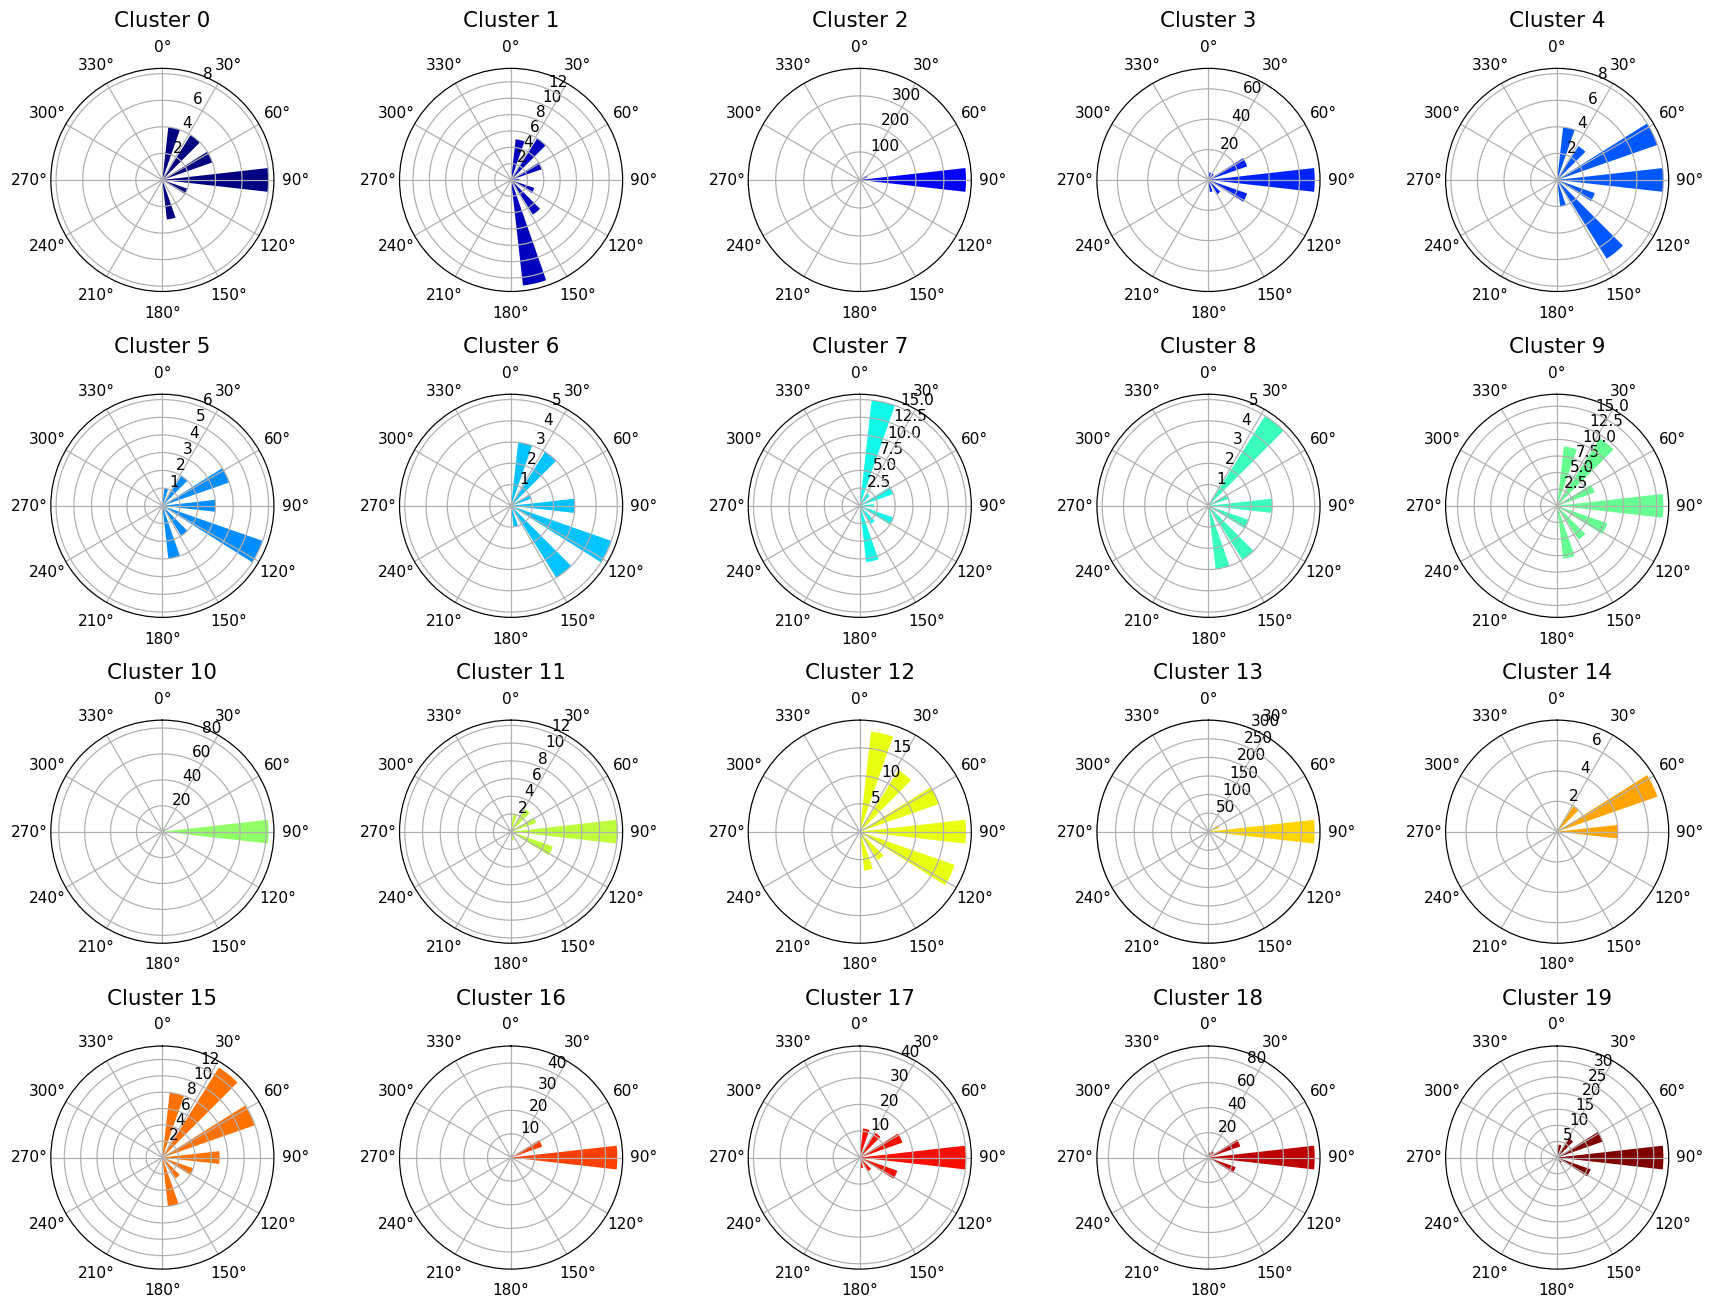

In [108]:
rose_plot(log_ri_list[0],nclusters, cmap='jet',figsize=(16,12),dpi=110,nrows=4, ncols=5)

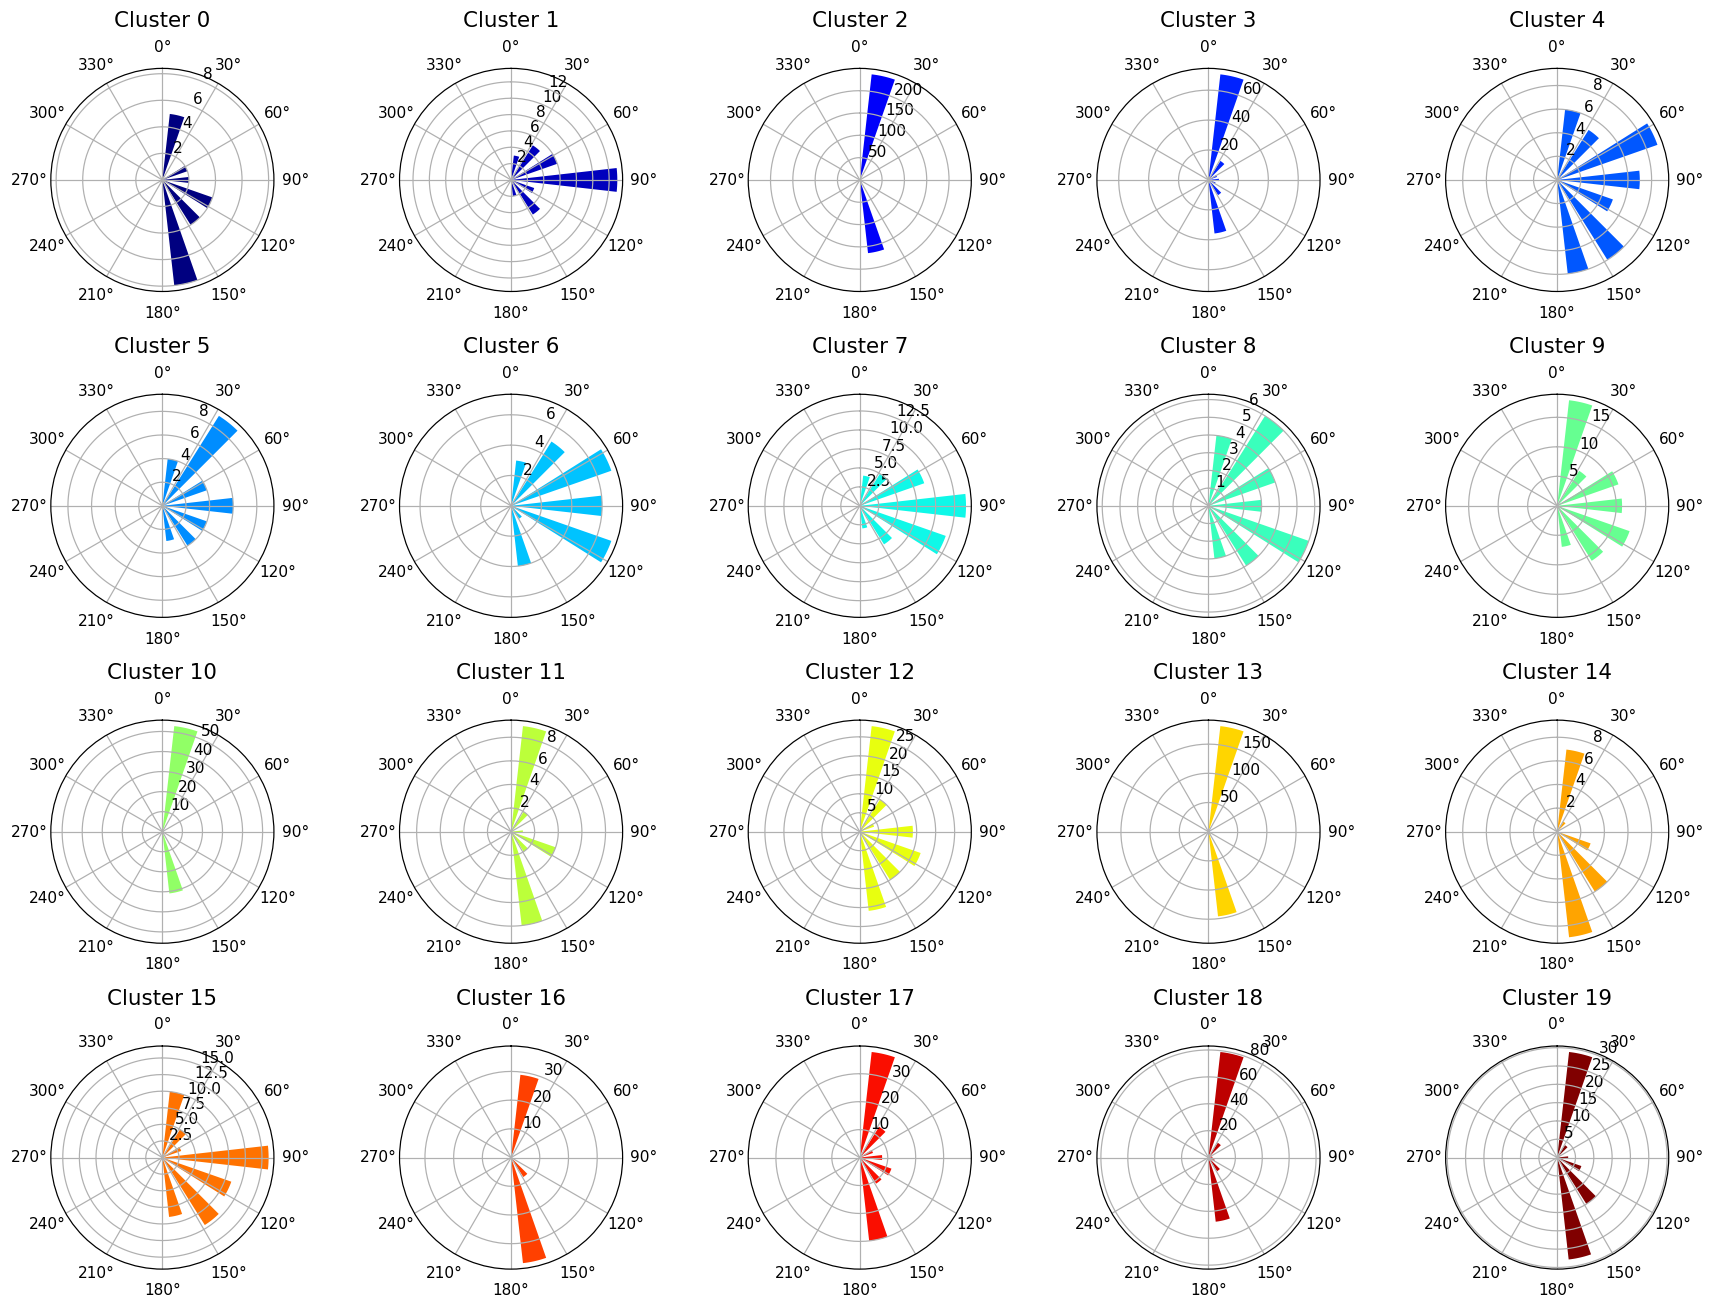

In [91]:
rose_plot(log_ri_list[1],nclusters, cmap='jet',figsize=(16,12),dpi=110,nrows=4, ncols=5)

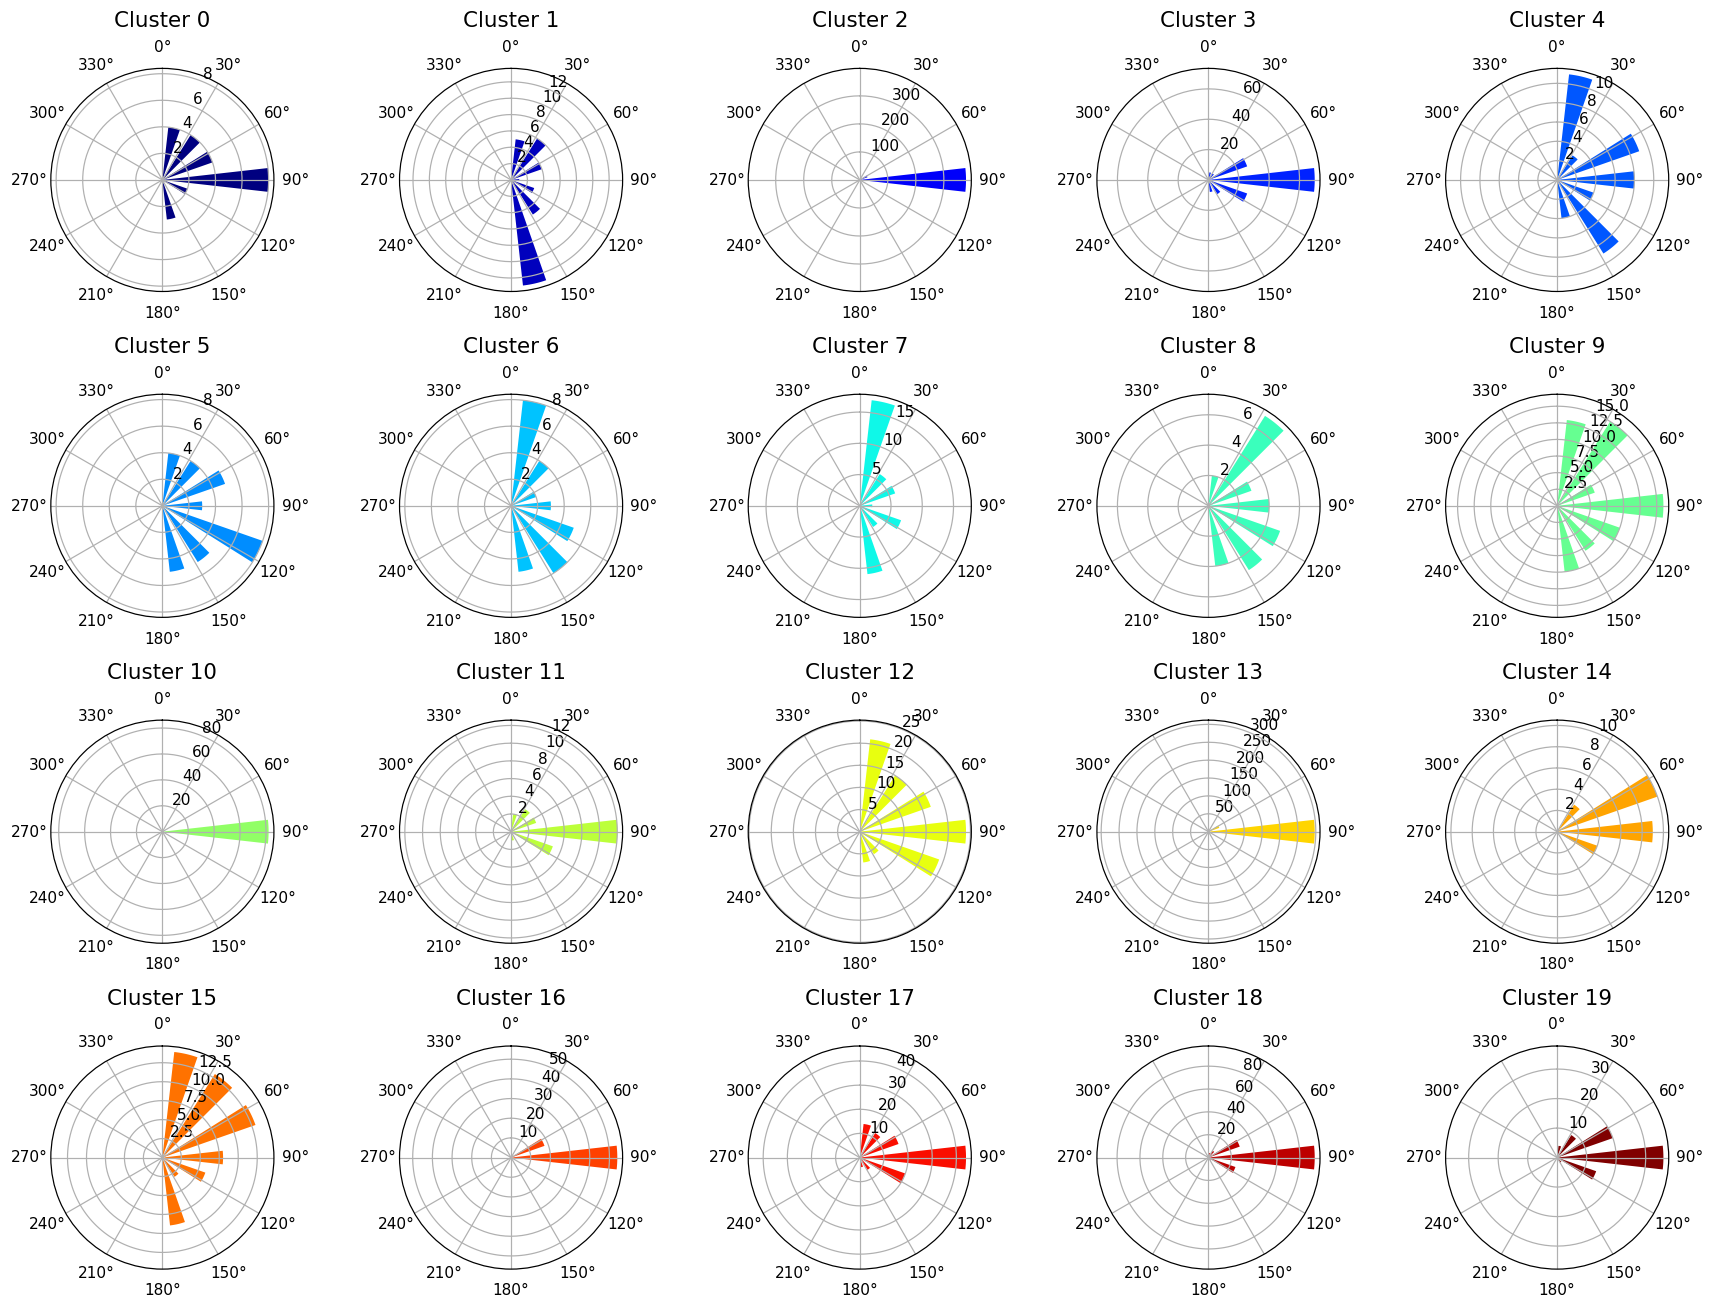

In [92]:
rose_plot(log_ri_list[2],nclusters, cmap='jet',figsize=(16,12),dpi=110,nrows=4, ncols=5)

In [21]:
ri_hist_clusters = [2,3,10,11,13,16,17,18,19]

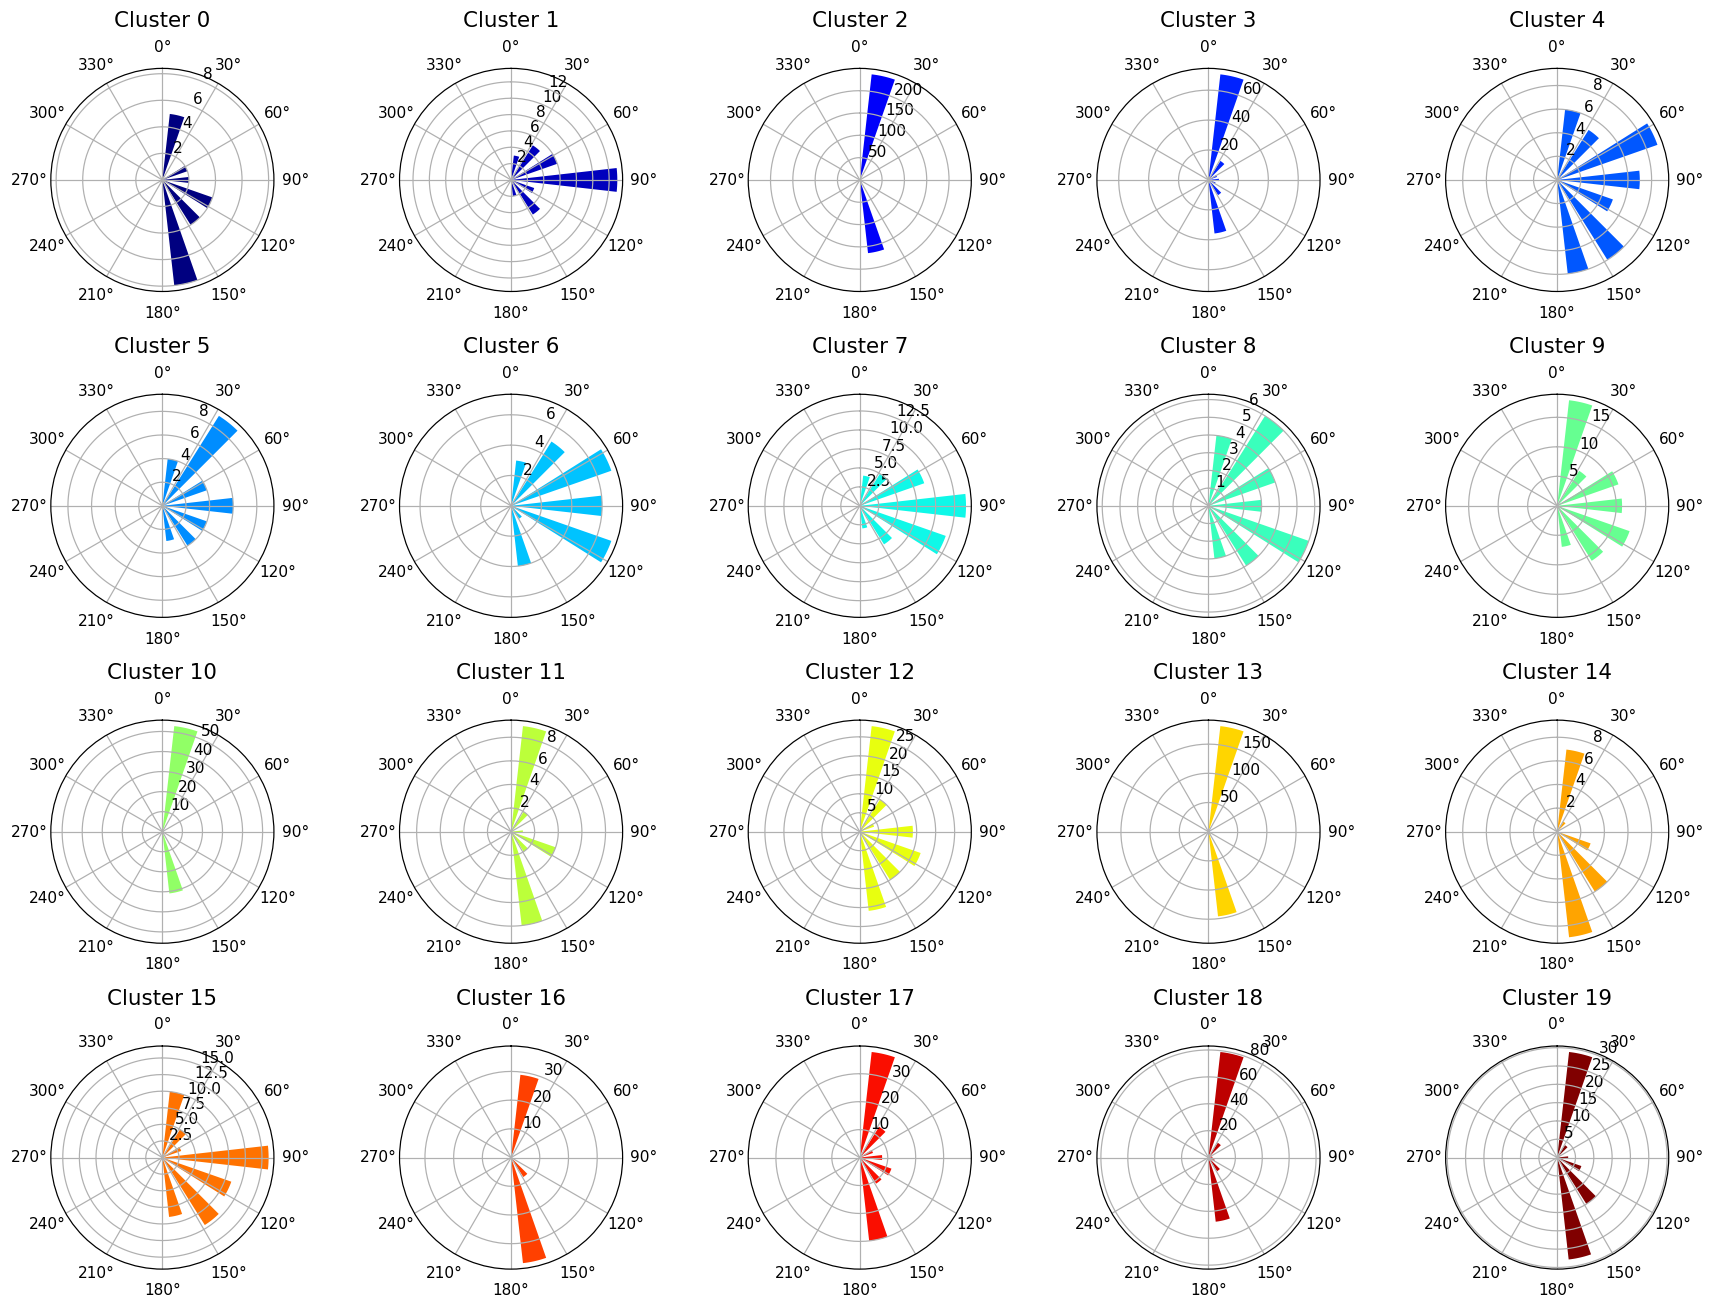

In [93]:
rose_plot(log_ri_list[3],nclusters, cmap='jet',figsize=(16,12),dpi=110,nrows=4, ncols=5)

-------------------
#### No-RI model

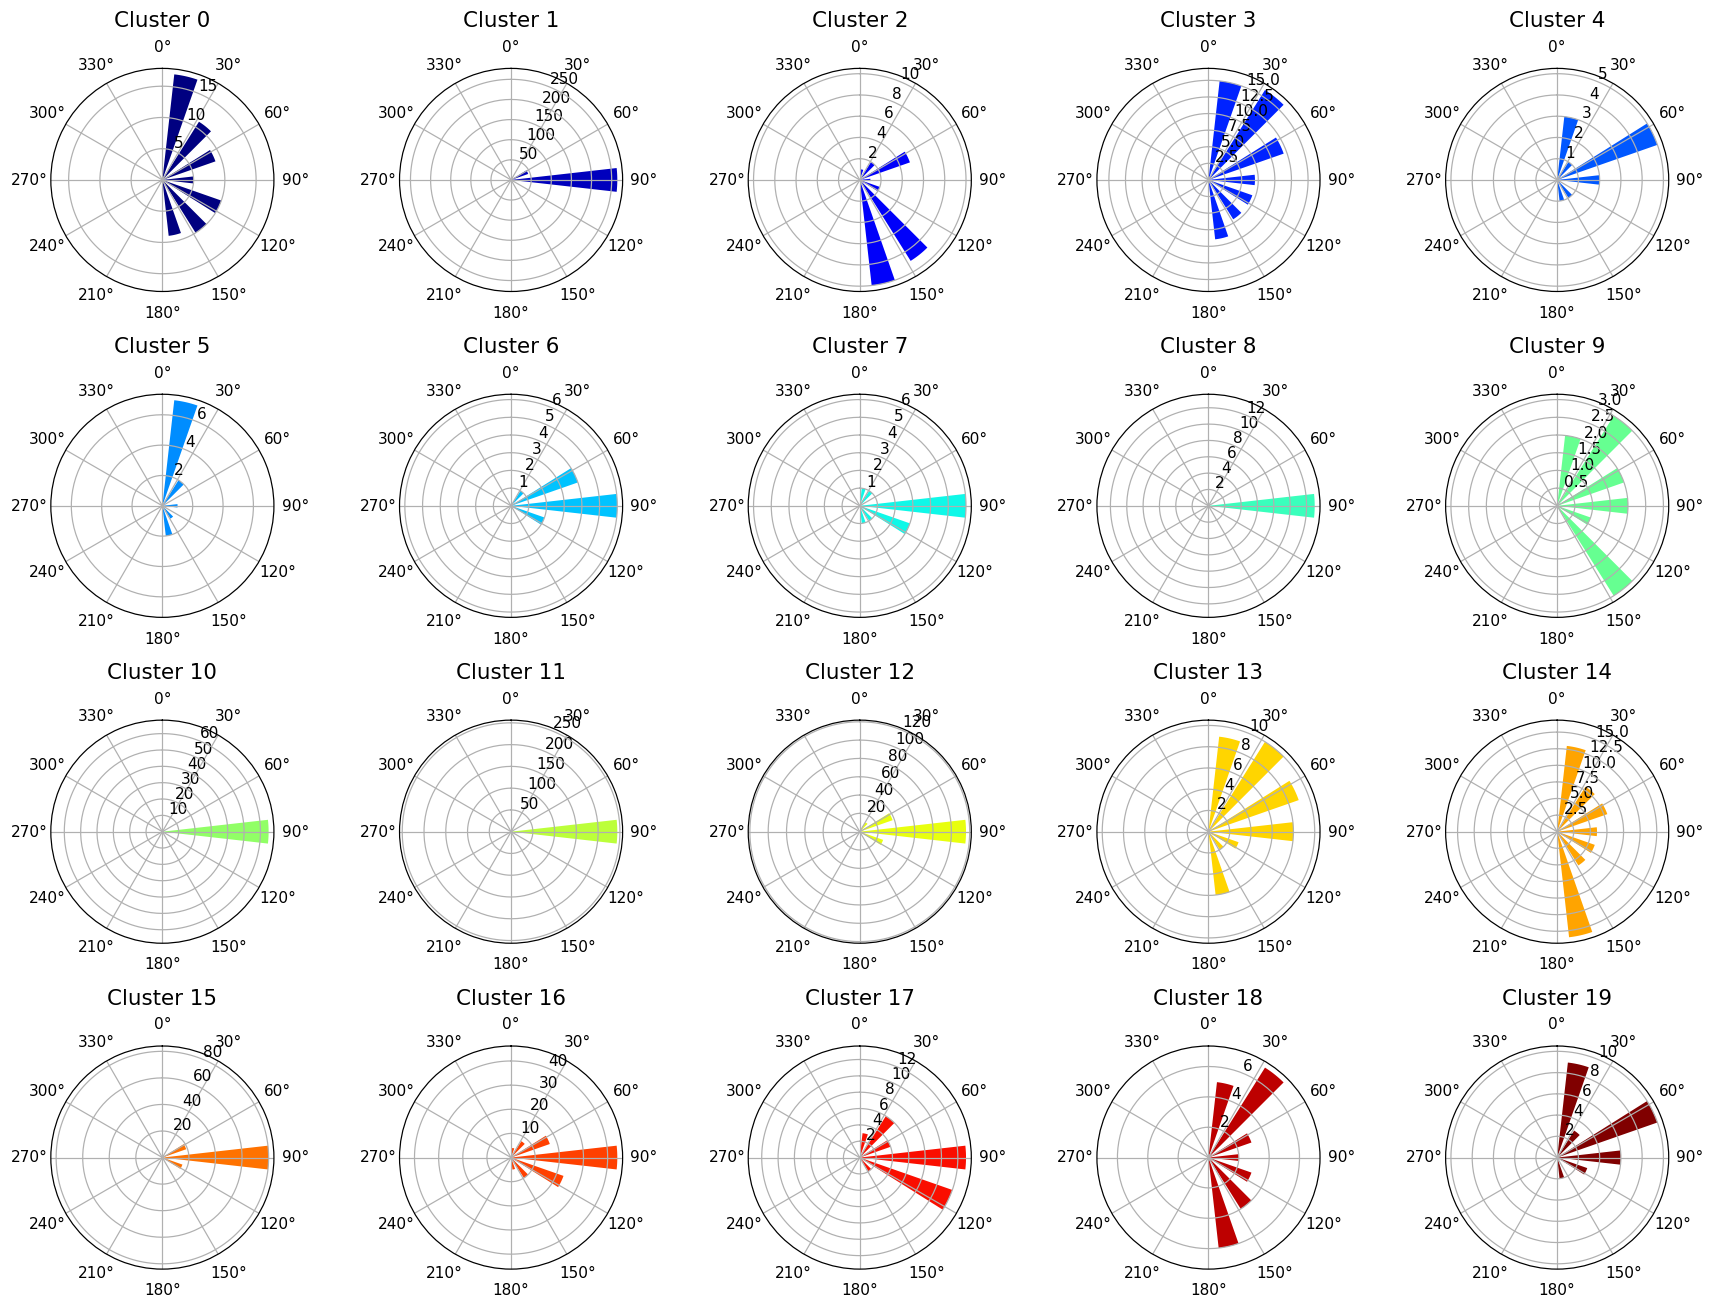

In [23]:
rose_plot(log_nori_list[0],nclusters, cmap='jet',figsize=(16,12),dpi=110,nrows=4, ncols=5)

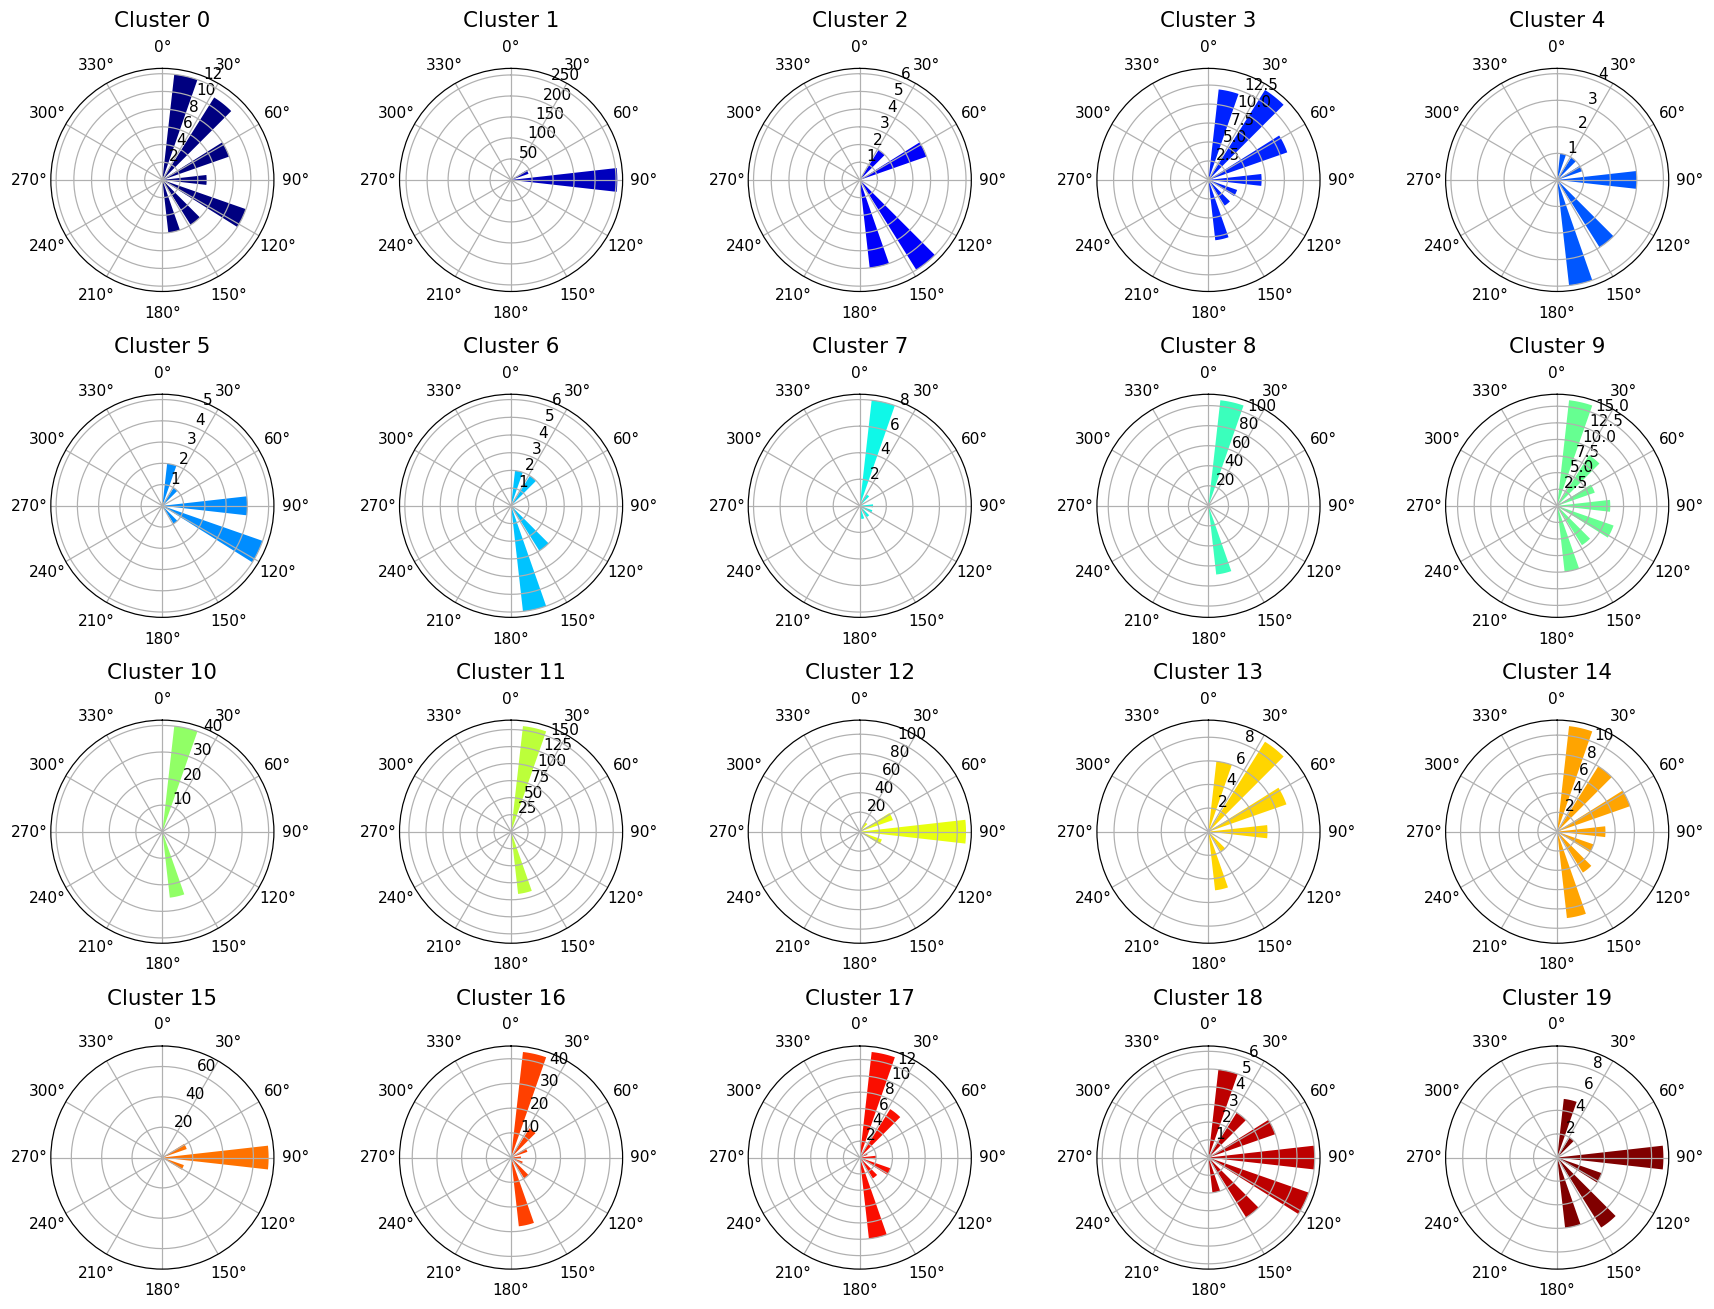

In [20]:
rose_plot(log_nori_list[1],nclusters, cmap='jet',figsize=(16,12),dpi=110,nrows=4, ncols=5)

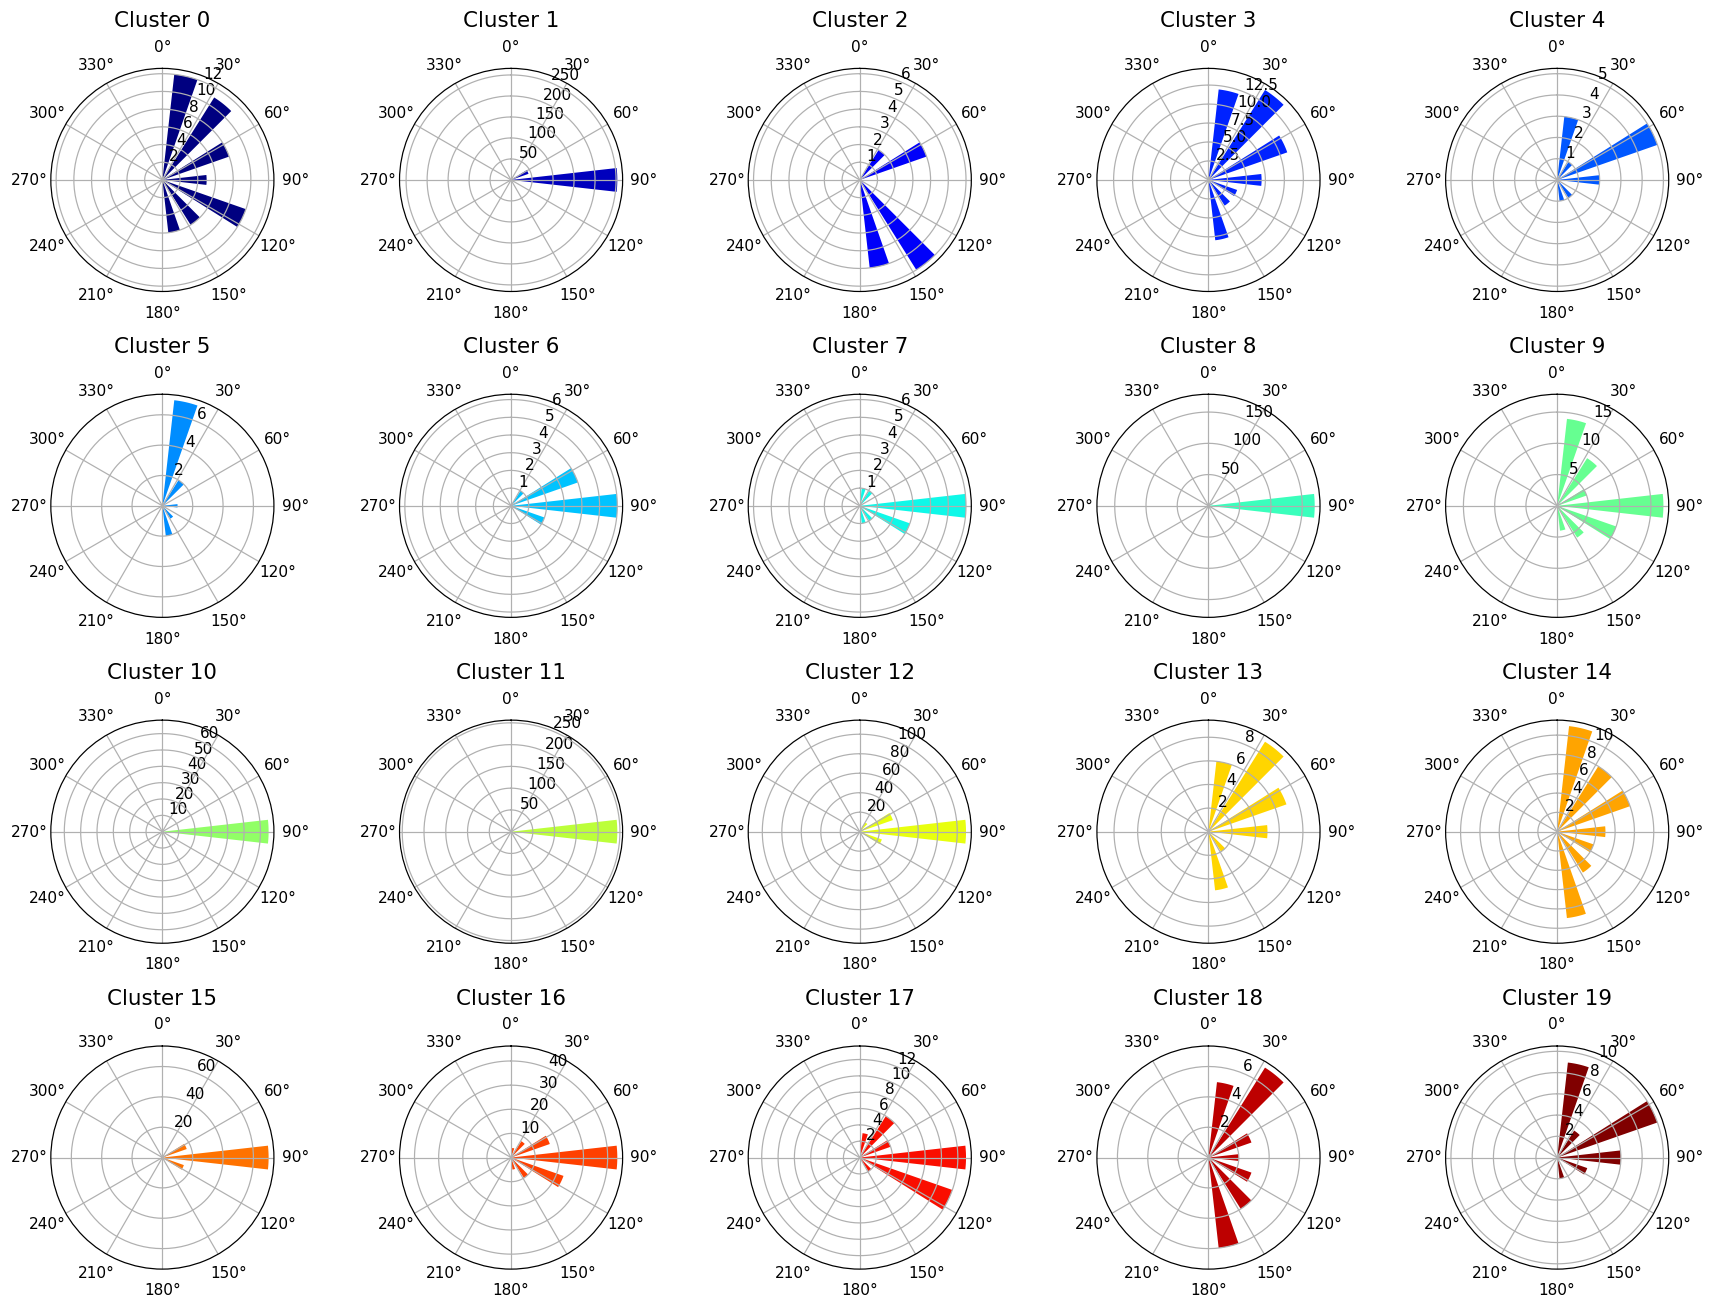

In [21]:
rose_plot(log_nori_list[2],nclusters, cmap='jet',figsize=(16,12),dpi=110,nrows=4, ncols=5)

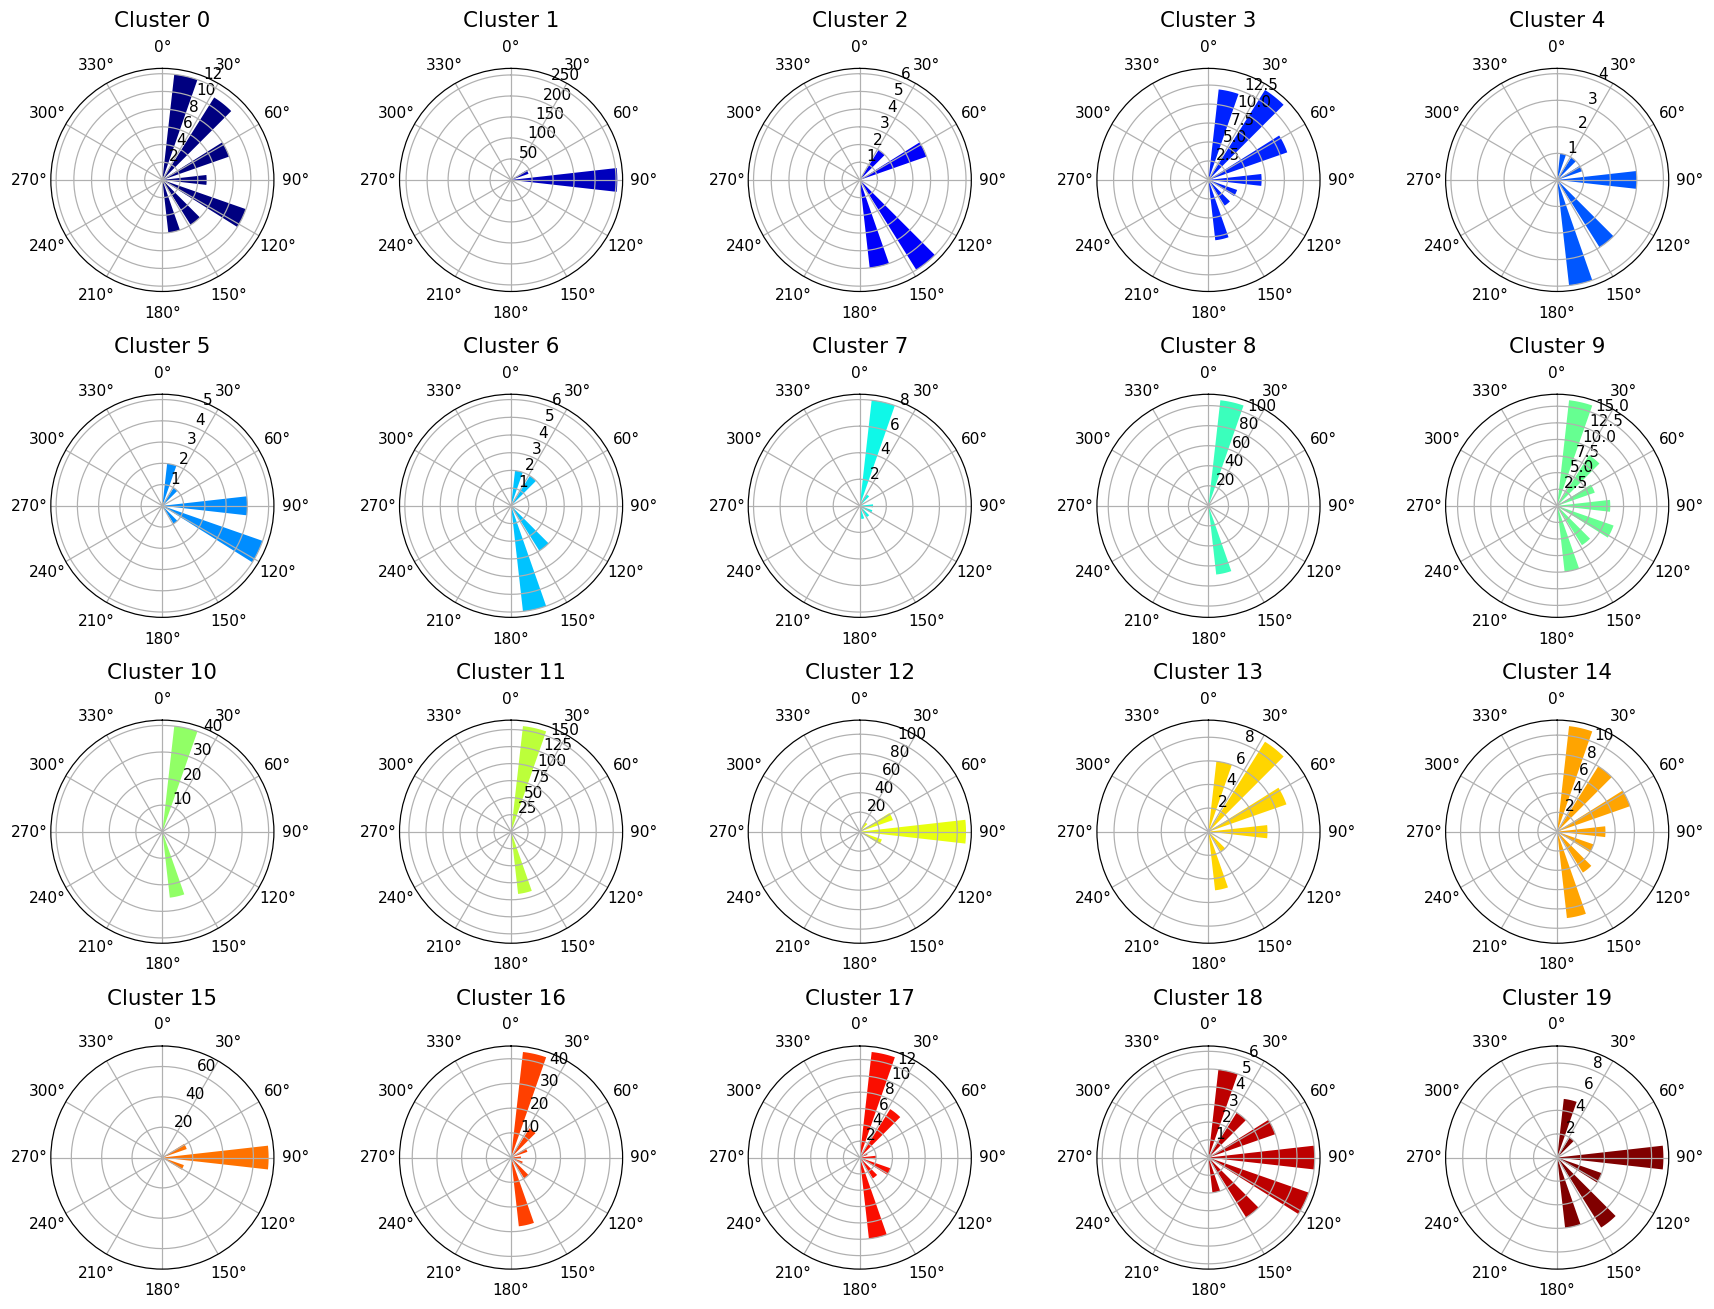

In [22]:
rose_plot(log_nori_list[3],nclusters, cmap='jet',figsize=(16,12),dpi=110,nrows=4, ncols=5)

----
### Visualize top K figures for residual degree 